In [24]:
import os
import sys
sys.path.append('../../')

import os
import mlflow
import mlflow.pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from ieeg_dataset import IeegDataset  
import json
from sklearn.preprocessing import LabelEncoder
from typing import Tuple, Dict
from tqdm.notebook import tqdm



In [8]:
## MLFLOW Setup
os.environ['AWS_ACCESS_KEY_ID'] = 'dIgexhE2iDrGls2qargL'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'IzEzgQpztotDnrIInJdUfUIYngpjJoT18d0FDZf7'
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://localhost:9000'
os.environ['MLFLOW_S3_IGNORE_TLS'] = 'true'
os.environ["MLFLOW_ENABLE_SYSTEM_METRICS_LOGGING"] = "true"
mlflow.set_tracking_uri("http://localhost:5000")
print('tracking uri:', mlflow.get_tracking_uri())

tracking uri: http://localhost:5000


In [47]:
# Configuration
DATA_DIR = '../../data/test/include'  # Directory containing the test data
MODEL_NAME = 'CNN_TNN_optimized_2_no_ss'
MODEL_NAME_LESS_E = 'best_cnn_tnn_model'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
RESULTS_DIR = './results'
PLOTS_DIR = './plots'
VERSION = 2
# Ensure results an

In [48]:
artifact_path = 'mlflow-artifacts:/17/b180b27e0fdd47459499fa5b6bac91fe/artifacts/class_mapping.json'

In [49]:
# Load the class mapping from the artifacts
class_mapping_path = mlflow.artifacts.download_artifacts(artifact_uri=artifact_path)
with open(class_mapping_path, 'r') as f:
    class_mapping = json.load(f)

# Convert class mapping to have int keys
class_mapping = {int(k): v for k, v in class_mapping.items()}

# Create label encoder from class mapping
def create_label_encoder(class_mapping: Dict[int, str]) -> LabelEncoder:
    label_encoder = LabelEncoder()
    classes = [class_mapping[i] for i in range(len(class_mapping))]
    label_encoder.fit(classes)
    return label_encoder

label_encoder = create_label_encoder(class_mapping)

In [56]:
model_uri = f"models:/{MODEL_NAME}/{2}"
model = mlflow.pytorch.load_model(model_uri=model_uri)

2024/06/28 14:05:57 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


In [57]:
model.to(DEVICE)

ConvTransformerModel(
  (conv_embedding_stem): ConvEmbeddingStem(
    (conv1): Conv1d(1, 256, kernel_size=(10,), stride=(2,), padding=(4,), bias=False)
    (act1): GELU(approximate='none')
    (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout(p=0.4, inplace=False)
    (conv2): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (act2): GELU(approximate='none')
    (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout(p=0.4, inplace=False)
    (conv3): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
    (act3): GELU(approximate='none')
    (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout3): Dropout(p=0.4, inplace=False)
  )
  (transformer_blocks): ModuleList(
    (0-1): 2 x MultiheadSelfAttentionBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=Tr

In [58]:
test_dataset = IeegDataset(data_dir=DATA_DIR, seq_length=500, model_type='cnn')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

Applying this mapping: {'CA': 0, 'CA1': 1, 'Thalamus': 2, 'vM1': 3}


In [59]:
import scienceplots
plt.style.use(['science','ieee', 'grid', 'std-colors'])


In [60]:
def evaluate_model(model, test_loader, device, class_mapping, results_dir, plots_dir):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Include all classes in the confusion matrix
    all_classes = list(class_mapping.keys())

    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=all_classes)
    cm_df = pd.DataFrame(cm, index=[class_mapping[i] for i in all_classes], 
                         columns=[class_mapping[i] for i in all_classes])

    # Save metrics
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    metrics_path = os.path.join(results_dir, 'metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f)

    # Log metrics to MLflow

    # Plot and save confusion matrix
    plt.figure()
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix Data Out of The Distribution')
    cm_plot_path = os.path.join(plots_dir, 'confusion_matrix.png')
    plt.savefig(cm_plot_path)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

Evaluating:   0%|          | 0/105 [00:00<?, ?batch/s]

Accuracy: 0.1472
Precision: 0.4723, Recall: 0.1472, F1 Score: 0.2244


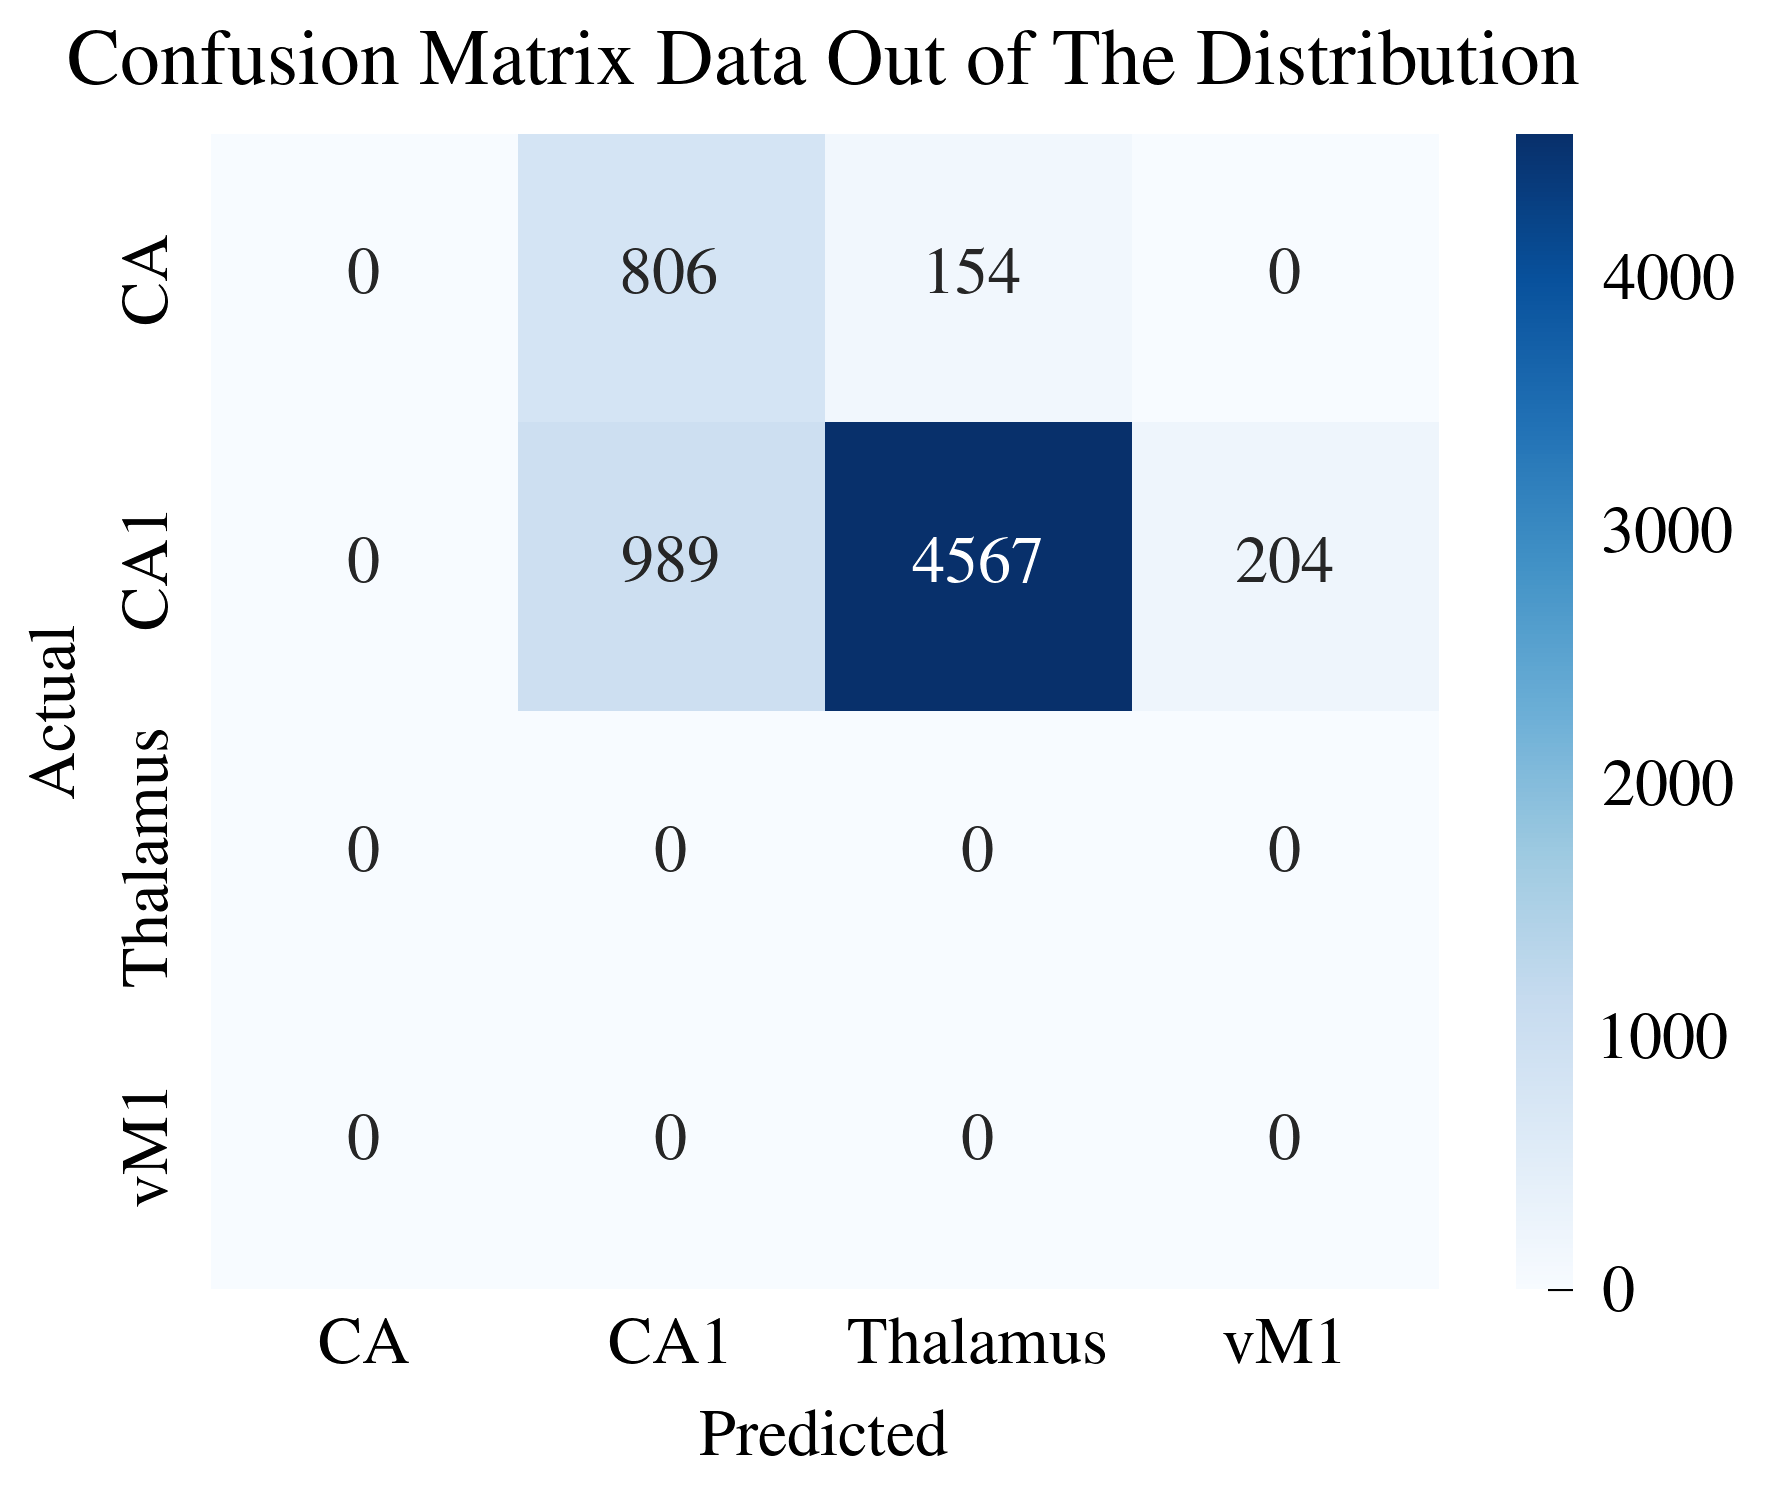

In [61]:
# Get class mapping
class_mapping = test_dataset.get_class_mapping()

# Evaluate the model
evaluate_model(model, test_loader, DEVICE, class_mapping, RESULTS_DIR, PLOTS_DIR)


In [22]:
class_mapping

{0: 'CA', 1: 'CA1', 2: 'Thalamus', 3: 'vM1'}